# Alignment Error Visualization

This notebook collects COM data from the database and tries to quantify some alignment errors. The main results are shown in the plots at the end of the notebook.

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import func
from collections import OrderedDict

sns.set_style("whitegrid")

PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix() + '/src'
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)


/home/eddyod/programming/pipeline/src


In [2]:
from library.controller.sql_controller import SqlController
from library.image_manipulation.filelocation_manager import FileLocationManager
from library.utilities.utilities_process import M_UM_SCALE, SCALING_FACTOR, random_string, read_image, write_image


In [3]:
def list_coms(animal):
    """
    Lists the COMs from the annotation session table. The data
    is stored in meters so you will want to convert it to micrometers
    and then by the resolution of the scan run.
    """
    sqlController = SqlController(animal)
    xy_resolution = sqlController.scan_run.resolution
    z_resolution = sqlController.scan_run.zresolution
    coms = {}
    annotator_id = 1 # Hardcoded to edward
    com_dictionaries = sqlController.get_com_dictionary(prep_id=animal, annotator_id=annotator_id)
    for k, v in com_dictionaries.items():
        #x = round(v[0] * M_UM_SCALE / xy_resolution, 2)
        #y = round(v[1] * M_UM_SCALE / xy_resolution, 2)
        #z = round(v[2] * M_UM_SCALE / z_resolution, 2)
        x = round(v[0] * M_UM_SCALE , 2)
        y = round(v[1] * M_UM_SCALE , 2)
        z = round(v[2] * M_UM_SCALE , 2)
        coms[k] = (x,y,z)

    return coms

def apply_affine_transformations(points, matrix):
    """
    Applies an affine transformation to a set of (x, y, z) coordinates.
    
    Parameters:
        points (array-like): A list or array of shape (N, 3) containing N points in (x, y, z) format.
        matrix (array-like): A 4x4 affine transformation matrix.

    Returns:
        numpy.ndarray: Transformed points as an (N, 3) array.
    """
    points = np.asarray(points)
    matrix = np.asarray(matrix)
    
    if points.shape[1] != 3:
        raise ValueError("Each point must have exactly three coordinates (x, y, z).")
    if matrix.shape != (4, 4):
        raise ValueError("The transformation matrix must be a 4x4 matrix.")
    
    # Convert points to homogeneous coordinates by adding a 1 to each point
    ones = np.ones((points.shape[0], 1))
    homogeneous_points = np.hstack([points, ones])
    
    # Apply the affine transformation
    transformed_points = homogeneous_points @ matrix.T
    
    # Convert back to Cartesian coordinates
    return transformed_points[:, :3]

def apply_affine_transform(point, matrix):
    """
    Applies an affine transformation to a 3D point.

    Parameters:
    point (tuple or list): A tuple (x, y, z) representing the 3D point.
    matrix (numpy array): A 4x4 affine transformation matrix.

    Returns:
    numpy array: Transformed (x', y', z') coordinates as a numpy array.
    """
    if len(point) != 3:
        raise ValueError("Point must be a 3-element tuple or list (x, y, z)")
    
    if matrix.shape != (4, 4):
        raise ValueError("Matrix must be a 4x4 numpy array")
    
    # Convert the point to homogeneous coordinates
    homogeneous_point = np.array([point[0], point[1], point[2], 1])
    
    # Apply the transformation
    transformed_point = np.dot(matrix, homogeneous_point)
    
    # Return the transformed x, y, z coordinates (ignoring the homogeneous coordinate)
    return transformed_point[:3]

def absolute_sum(l):
    la = np.array(l)
    #nabs = np.abs(np.array(la))
    return np.sum(la, axis=0)

def plot_xyz_point(xyz):
    x,y,z = xyz
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the point
    ax.scatter(x, y, z, color='r', s=100, label=f'Point ({x}, {y}, {z})')
    
    # Set labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('3D Coordinate Plot')
    
    # Set limits
    ax.set_xlim([0, 1320])
    ax.set_ylim([0, 800])
    ax.set_zlim([0, 1140])
    
    # Show grid
    ax.grid(True)
    ax.legend()
    plt.show()

## Data Collection

In [4]:
atlas_structures = list_coms('Atlas')
allen_structures = list_coms('Allen')


common_structures = set()

common_keys = sorted(list(allen_structures.keys() & atlas_structures.keys()))
atlas_items = {k:v for k,v in atlas_structures.items() if k in common_keys}
atlas_points = list(map(list, atlas_items.values()))
print(len(atlas_points))

37


In [8]:
affine_transform0 = np.array([
    [ 9.36873602e-01,  6.25910930e-02,  3.41078823e-03,  4.07945327e+02],
    [ 5.68396089e-04,  1.18742192e+00,  6.28369930e-03,  4.01267566e+01],
    [-1.27831427e-02,  8.42516452e-03,  1.11913658e+00, -6.42895756e+01],
    [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]
 ]
)
affine_transform1 = np.array([
[-1.99836563e-01,  2.86932273e-04, -5.27493715e-02,  1.25044784e+04],
 [-9.12271362e-02,  5.26784086e-02,  2.54441084e-01,  4.94949865e+03],
 [-1.32606966e-02, -6.42412889e-03,  1.38274977e-01,  4.28133389e+03],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]
    )
#error0 = [135845.  14108.  21411.]
#error1 = [ 3276. 45718. 24330.] [148290.   6973.  25009.]

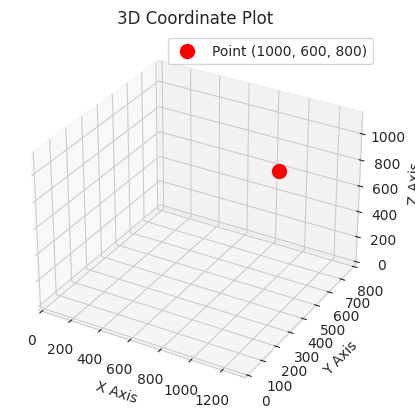

In [10]:
big_set = apply_affine_transformations(atlas_points, affine_transform1)
#print(big_set)
# rotating, sag to coronal
# x becomes z
# y stays the same
# z becomes x
x = 1000
y = 600
z = 800
test_point = (x, y, z)
SCA = (914, 238, 569)
sag = ()
plot_xyz_point(test_point)

In [11]:
errors = []
df_list = []
for structure in common_keys:
    atlas0 = atlas_structures[structure]
    allen = np.array(allen_structures[structure])    
    transformed = apply_affine_transform(atlas0, affine_transform1)
    transformed = [round(x,0) for x in transformed]
    difference = [round(a - b, 0) for a, b in zip(allen, transformed)]
    errors.append(difference)
    #print(structure, atlas_structures[structure], allen_structures[structure], transformed, difference)
    row = [structure, atlas_structures[structure], allen, difference]
    df_list.append(row)
result = absolute_sum(errors)
print(result)

[ -5092. -27473.  26376.]


In [12]:
columns = ['structure', 'atlas unaligned', 'allen', 'difference']
df = pd.DataFrame(df_list, columns=columns)
df.index.name = 'Index'
df.head(40)

,structure,atlas unaligned,allen,difference
Index,,,,
0,3N_L,"(6756.34, 2915.39, 5574.45)","[9102.49, 3794.35, 5520.97]","[-1759.0, -2111.0, 577.0]"
1,3N_R,"(6756.34, 2915.39, 5825.55)","[9103.39, 3793.96, 5864.36]","[-1745.0, -2175.0, 885.0]"
2,4N_L,"(7092.37, 2967.33, 5452.27)","[9588.57, 3777.83, 5432.47]","[-1211.0, -2068.0, 510.0]"
3,4N_R,"(7092.37, 2967.33, 5947.73)","[9586.8, 3774.79, 5952.9]","[-1187.0, -2197.0, 962.0]"
4,5N_L,"(7667.91, 4021.31, 4328.86)","[10193.03, 5286.55, 4091.63]","[-552.0, -276.0, -660.0]"
5,5N_R,"(7667.91, 4021.31, 7071.14)","[10193.42, 5285.53, 7292.79]","[-407.0, -975.0, 2161.0]"
6,6N_L,"(8262.31, 4123.98, 5337.87)","[10771.23, 5214.76, 5290.86]","[198.0, -556.0, 408.0]"
7,6N_R,"(8262.31, 4123.98, 6062.13)","[10771.44, 5214.59, 6094.08]","[236.0, -740.0, 1110.0]"
8,7N_L,"(8394.52, 5157.32, 4557.69)","[10852.7, 6775.45, 4339.98]","[265.0, 1160.0, -427.0]"


In [ ]:
def prepare_table(brains, person_id, input_type_id, save_path):
    df_save = prepare_table_for_save(
        brains,
        person_id=person_id,
        input_type_id=input_type_id
    )
    df_save.to_csv(save_path, index=False)
    
    df = prepare_table_for_plot(
        brains,
        person_id=person_id,
        input_type_id=input_type_id
    )

    return df_save, df

def get_brain_coms(brains, person_id, input_type_id):
    brain_coms = {}
    for brain in brains:
        brain_coms[brain] = query_brain_coms(
            brain,
            person_id=person_id,
            input_type_id=input_type_id
        )
        # A temporary hack: for ('DK55', corrected), use ('DK55', aligned)
        if (brain, input_type_id) == ('DK55', 2):
            brain_coms[brain] = query_brain_coms(
                brain,
                person_id=person_id,
                input_type_id=4
            )
    return brain_coms

def prepare_table_for_save(brains, person_id, input_type_id):
    brain_coms = get_brain_coms(brains, person_id, input_type_id)

    data = {}
    data['name'] = []
    for s in common_structures:
        for c in ['dx', 'dy', 'dz', 'dist']:
            data['name'] += [f'{s}_{c}']
    for brain in brain_coms.keys():
        data[brain] = []
        offset = [brain_coms[brain][s] - atlas_coms[s]
                  if s in brain_coms[brain] else [np.nan, np.nan, np.nan]
                  for s in common_structures]
        offset = np.array(offset)
        scale = np.array([10, 10, 20])
        dx, dy, dz = (offset * scale).T
        dist = np.sqrt(dx * dx + dy * dy + dz * dz)
        for dx_i, dy_i, dz_i, dist_i in zip(dx, dy, dz, dist):
            data[brain] += [dx_i, dy_i, dz_i, dist_i]
    df = pd.DataFrame(data)

    return df

def prepare_table_for_plot(brains, person_id, input_type_id):
    brain_coms = get_brain_coms(brains, person_id, input_type_id)

    df = pd.DataFrame()
    for brain in brain_coms.keys():
        offset = [brain_coms[brain][s] - atlas_coms[s]
                  if s in brain_coms[brain] else [np.nan, np.nan, np.nan]
                  for s in common_structures]
        offset = np.array(offset)
        scale = np.array([10, 10, 20])
        dx, dy, dz = (offset * scale).T
        dist = np.sqrt(dx * dx + dy * dy + dz * dz)

        df_brain = pd.DataFrame()

        data = {}
        data['structure'] = common_structures
        data['value'] = dx
        data['type'] = 'dx'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = common_structures
        data['value'] = dy
        data['type'] = 'dy'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = common_structures
        data['value'] = dz
        data['type'] = 'dz'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        data = {}
        data['structure'] = common_structures
        data['value'] = dist
        data['type'] = 'dist'
        df_brain = df_brain.append(pd.DataFrame(data), ignore_index=True)

        df_brain['brain'] = brain
        df = df.append(df_brain, ignore_index=True)
    return df

In [ ]:
def plot(df, ymin, ymax, ystep, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 12), dpi=200)
    
    sns.boxplot(ax=ax[0], x="structure", y="value", hue="type", data=df)
    ax[0].xaxis.grid(True)
    ax[0].set_xlabel('Structure')
    ax[0].set_ylabel('um')
    ax[0].set_title('full dynamic range')
    
    sns.boxplot(ax=ax[1], x="structure", y="value", hue="type", data=df)
    ax[1].xaxis.grid(True)
    ax[1].set_ylim(ymin, ymax)
    ax[1].yaxis.set_ticks(np.arange(ymin, ymax + 1, ystep))
    ax[0].set_xlabel('Structure')
    ax[1].set_ylabel('um')
    ax[1].set_title('zoom in')
    
    fig.suptitle(title, y=0.92)
    plt.show()
    return fig

figs = []

## Rigid Alignment Error

Rigid alignment error is computed as follows:
1. Anotomist manually annotate the COMs for each brain.
2. Computer finds the best transformation between atlas COMs and **anotomist's manual COMs**. The transformation is restricted to rigid + uniform scaling.
3. Using the transformation, the **anotomist's manual COMs** are brought to the atlas space.
4. The errors between the 2 sets of COMs are calculated, and displayed in the following plots.

The errors for a single structure are quantified by 4 numbers: dx, dy, dz, dist. (dx, dy, dz) are the offset. dist is the corresponding distance of the offset.

In [ ]:
brain_coms = get_brain_coms(brains_to_examine,person_id=28,
    input_type_id=4)

In [ ]:
# person is bili, input_type is aligned
df_save, df = prepare_table(
    brains_to_examine,
    person_id=28,
    input_type_id=4,
    save_path='../data/rigid-alignment-error.csv'
)
df_save.head()

In [ ]:
fig = plot(df, -1000, 1000, 100, 'Rigid Alignment Error')
figs.append(fig)

## Rigid Alignment Error After Correction

After reviewing the rigid alignment error plots, Beth manually re-annotatted the significant outliers as a correction. With this updated data, we compute the alignment error again using the same method.

In [ ]:
# person is bili, input_type is corrected
df_save, df = prepare_table(
    brains_to_examine,
    person_id=28,
    input_type_id=2,
    save_path='../data/rigid-alignment-error-after-correction.csv'
)
df_save.head()

In [ ]:
fig = plot(df, -1000, 1000, 100, 'Rigid Alignment Error After Correction')
figs.append(fig)

## Rough Alignment Error

**Rough alignment** is an **automatic method** to find the best 3D affine transformation between 2 brains, solely based on the thumbnail-resolution gray value images. Rough alignment is planned to be the first step of an automatic pipeline, which defines the starting points for Kui's automatic detection method.

We start with an anotomist manually annotate the COMs extensively for one brain (DK52).

Rough alignment error is computed as follows:
1. Computer finds the best 3D affine transformation between DK52 and the brain, as determined by aligning the gray value images.
2. Using the transformation, the DK52 COMs are brought to that brain's space. And we call it the **rough COMs** of the brain.
3. Computer finds the best transformation between atlas COMs and **rough COMs**. The transformation is restricted to rigid + uniform scaling.
4. Using the transformation, the **rough COMs** are brought to the atlas space.
5. The errors between the 2 sets of COMs are calculated, and displayed in the following plots.

The errors for a single structure are quantified by 4 numbers: dx, dy, dz, dist. (dx, dy, dz) are the offset. dist is the corresponding distance of the offset.

In [ ]:
# person is ed, input_type is aligned
df_save, df = prepare_table(
    brains_to_examine,
    person_id=1,
    input_type_id=4,
    save_path='../data/rough-alignment-error.csv'
)
df_save.head()

In [ ]:
fig = plot(df, -1000, 1000, 100, 'Rough Alignment Error')
figs.append(fig)

## Generate Report

In [ ]:
with PdfPages('../data/alignment-error.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig)